In [ ]:
# Cell 1: Imports + Load NSL-KDD dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------------------------------
# Load NSL-KDD Train and Test
# -------------------------------
train_path = "KDDTrain+.txt"
test_path  = "KDDTest+.txt"

# Column names for NSL-KDD (41 features + label + difficulty level)
col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"
]

# Read datasets
df_train = pd.read_csv(train_path, names=col_names)
df_test  = pd.read_csv(test_path, names=col_names)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("\nExample rows:\n", df_train.head())


Train shape: (125973, 43)
Test shape: (22544, 43)

Example rows:
    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1     

In [ ]:
# Cell 2: Preprocessing NSL-KDD

# Drop 'difficulty' column (not needed)
df_train = df_train.drop(columns=["difficulty"])
df_test  = df_test.drop(columns=["difficulty"])

# -------------------------------
# Encode categorical features
# -------------------------------
categorical_cols = ["protocol_type", "service", "flag"]
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col]  = le.transform(df_test[col])  # same mapping
    encoders[col] = le

# -------------------------------
# Encode labels (attack classes)
# -------------------------------
# Binary labels: normal vs attack
df_train["label"] = df_train["label"].apply(lambda x: "normal" if x=="normal" else "attack")
df_test["label"]  = df_test["label"].apply(lambda x: "normal" if x=="normal" else "attack")

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_test  = label_encoder.transform(df_test["label"])

# -------------------------------
# Normalize numeric features
# -------------------------------
X_train = df_train.drop(columns=["label"]).values
X_test  = df_test.drop(columns=["label"]).values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# -------------------------------
# Convert to PyTorch tensors
# -------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("X_train:", X_train_tensor.shape, " y_train:", y_train_tensor.shape)
print("X_test:", X_test_tensor.shape, " y_test:", y_test_tensor.shape)
print("\nClasses:", label_encoder.classes_)


X_train: torch.Size([125973, 41])  y_train: torch.Size([125973])
X_test: torch.Size([22544, 41])  y_test: torch.Size([22544])

Classes: ['attack' 'normal']


In [ ]:
# Cell 3: Dataset & DataLoader

from torch.utils.data import TensorDataset, DataLoader

# Wrap tensors into TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Use DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # larger batch for speed
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


Train batches: 493
Test batches: 89


In [ ]:
# Cell 4: AegisFormer-IDS Model (Fast FT-Transformer style)

import torch
import torch.nn as nn

class AegisFormerIDS(nn.Module):
    def __init__(self, num_features, num_classes, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(AegisFormerIDS, self).__init__()

        # Feature projection (tokenization)
        self.input_proj = nn.Linear(num_features, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True   # so inputs are (batch, seq, feature)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [batch, features]
        x = self.input_proj(x).unsqueeze(1)  # -> [batch, seq=1, d_model]
        x = self.transformer(x)              # -> [batch, seq=1, d_model]
        x = x.mean(dim=1)                    # global average pooling
        return self.fc(x)                    # logits


In [ ]:
# Cell 5: Training Setup (Loss + Optimizer + Scheduler)

import torch.optim as optim

num_features = X_train.shape[1]   # number of input features after preprocessing
num_classes  = len(torch.unique(torch.tensor(y_train)))  # ✅ convert to tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AegisFormerIDS(
    num_features=num_features,
    num_classes=num_classes,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Optional learning rate scheduler (step down LR after 5 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"✅ Model initialized on {device} with {num_features} features and {num_classes} classes.")


✅ Model initialized on cpu with 41 features and 2 classes.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert numpy → torch tensors if not already
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Make dataset
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split into train (80%) + validation (20%)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# 📌 Cell 7: Training Loop (with validation)

from sklearn.metrics import accuracy_score, f1_score

num_epochs = 10
train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

for epoch in range(num_epochs):
    # -------------------------
    # Training
    # -------------------------
    model.train()
    running_loss, all_preds, all_labels = 0.0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1  = f1_score(all_labels, all_preds, average="weighted")

    train_losses.append(epoch_loss)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1  = f1_score(val_labels, val_preds, average="weighted")

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    scheduler.step()  # ✅ optional learning rate scheduler

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")


Epoch [1/10] Train Loss: 0.0280 Acc: 0.9892 F1: 0.9892 | Val Loss: 0.0245 Acc: 0.9898 F1: 0.9898
Epoch [2/10] Train Loss: 0.0248 Acc: 0.9902 F1: 0.9902 | Val Loss: 0.0238 Acc: 0.9902 F1: 0.9902
Epoch [3/10] Train Loss: 0.0236 Acc: 0.9909 F1: 0.9909 | Val Loss: 0.0228 Acc: 0.9918 F1: 0.9918
Epoch [4/10] Train Loss: 0.0226 Acc: 0.9914 F1: 0.9914 | Val Loss: 0.0212 Acc: 0.9915 F1: 0.9915
Epoch [5/10] Train Loss: 0.0208 Acc: 0.9921 F1: 0.9921 | Val Loss: 0.0209 Acc: 0.9919 F1: 0.9919
Epoch [6/10] Train Loss: 0.0186 Acc: 0.9930 F1: 0.9930 | Val Loss: 0.0180 Acc: 0.9935 F1: 0.9935
Epoch [7/10] Train Loss: 0.0173 Acc: 0.9932 F1: 0.9932 | Val Loss: 0.0180 Acc: 0.9927 F1: 0.9927
Epoch [8/10] Train Loss: 0.0168 Acc: 0.9935 F1: 0.9935 | Val Loss: 0.0178 Acc: 0.9929 F1: 0.9929
Epoch [9/10] Train Loss: 0.0167 Acc: 0.9937 F1: 0.9937 | Val Loss: 0.0170 Acc: 0.9927 F1: 0.9927
Epoch [10/10] Train Loss: 0.0163 Acc: 0.9938 F1: 0.9938 | Val Loss: 0.0166 Acc: 0.9939 F1: 0.9939


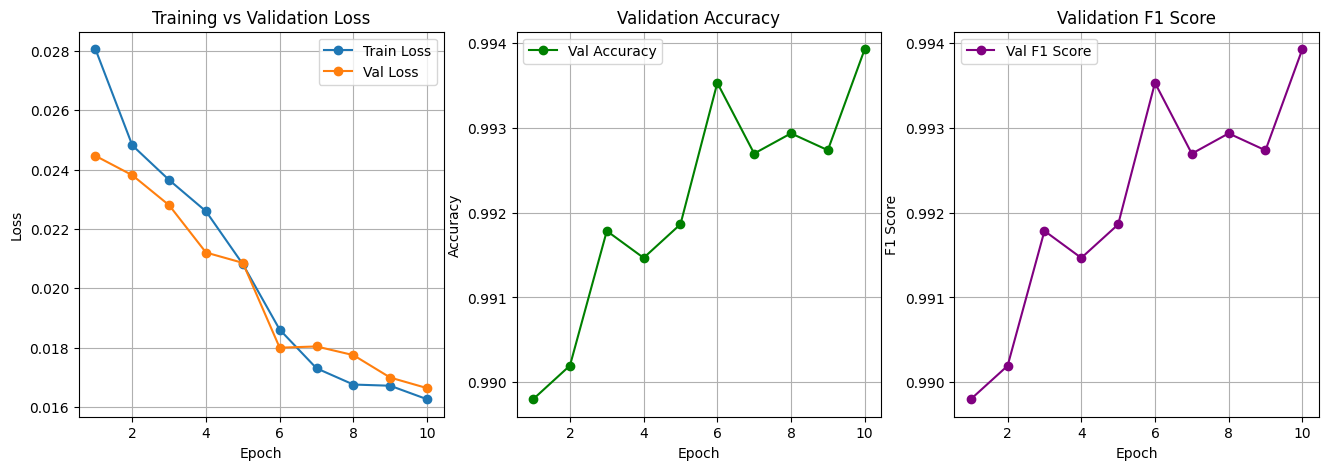

In [ ]:
# 📌 Cell 8: Plot Training & Validation Curves

import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(16,5))

# ---- Loss Curve ----
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy Curve ----
plt.subplot(1,3,2)
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

# ---- F1 Score Curve ----
plt.subplot(1,3,3)
plt.plot(epochs, val_f1s, label="Val F1 Score", marker='o', color='purple')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid(True)

plt.show()


✅ Test Accuracy: 78.5 %
✅ Test F1 Score: 78.27 %

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.64      0.77     12833
           1       0.67      0.98      0.80      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



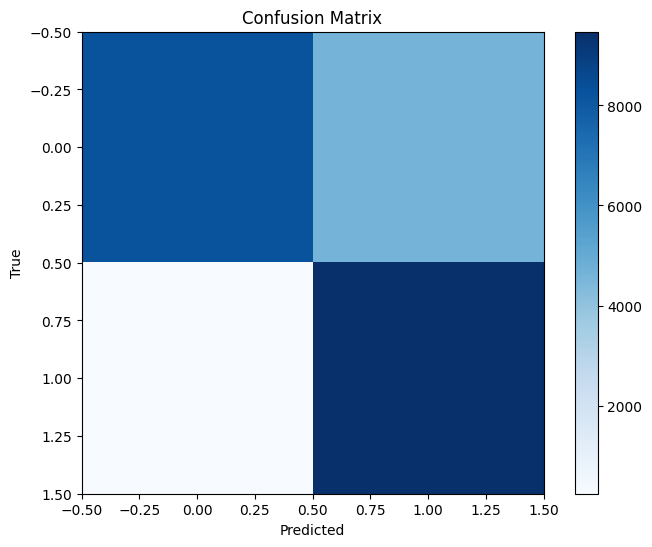

In [ ]:
# 📌 Cell 9: Final Evaluation on Test Set (KDDTest+)

from sklearn.metrics import classification_report, confusion_matrix

# Convert test data → torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Evaluation mode
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(yb.cpu().numpy())

# Accuracy & F1
test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average="weighted")

print("✅ Test Accuracy:", round(test_acc*100, 2), "%")
print("✅ Test F1 Score:", round(test_f1*100, 2), "%")

# Detailed report
print("\n📊 Classification Report:\n", classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# 📌 Cell 10: Save & Load Model for Deployment

import os

# Create folder to save model
os.makedirs("saved_models", exist_ok=True)

# Save model
model_path = "saved_models/aegisformer_ids.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at {model_path}")

# ------------------------
# To load later
# ------------------------
loaded_model = AegisFormerIDS(
    num_features=num_features,
    num_classes=num_classes,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
).to(device)

loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model.eval()

print("✅ Model reloaded and ready for inference!")


✅ Model saved at saved_models/aegisformer_ids.pth
✅ Model reloaded and ready for inference!


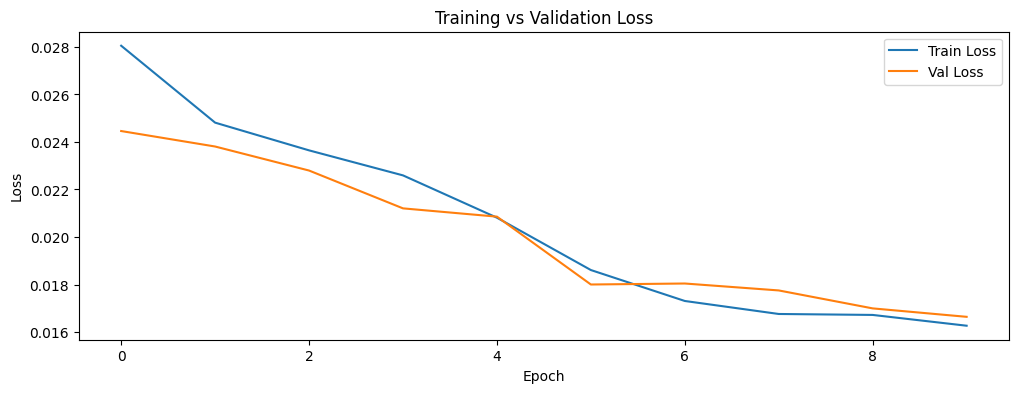

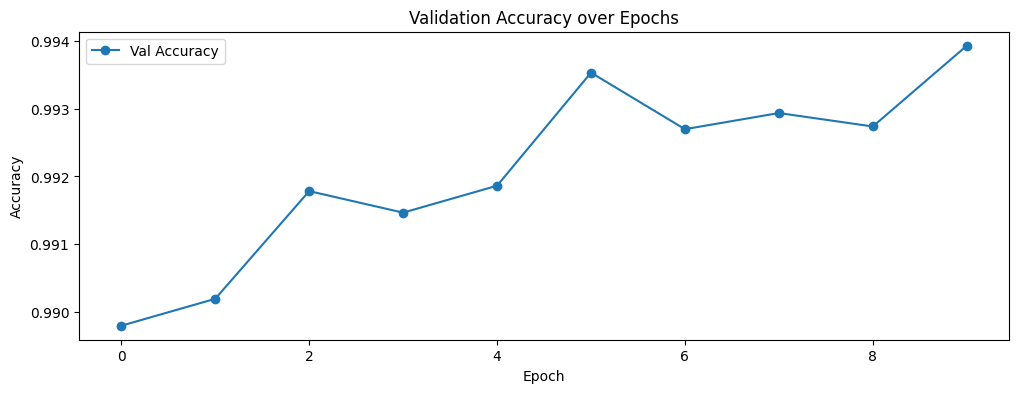

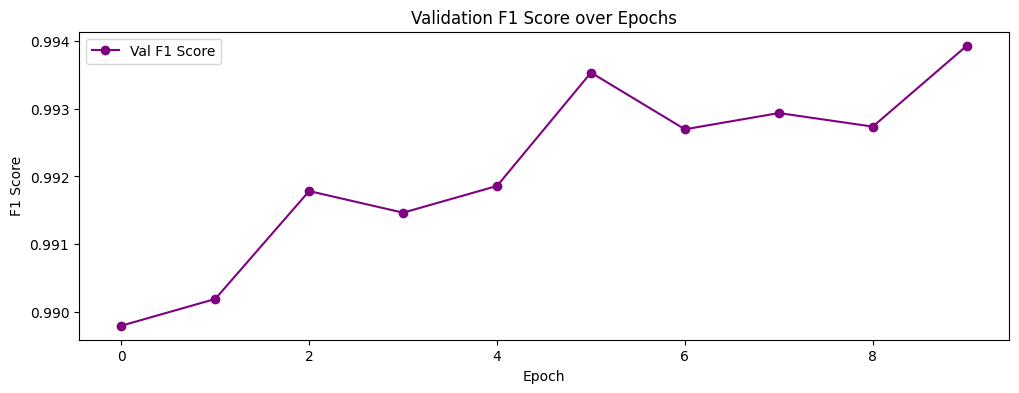

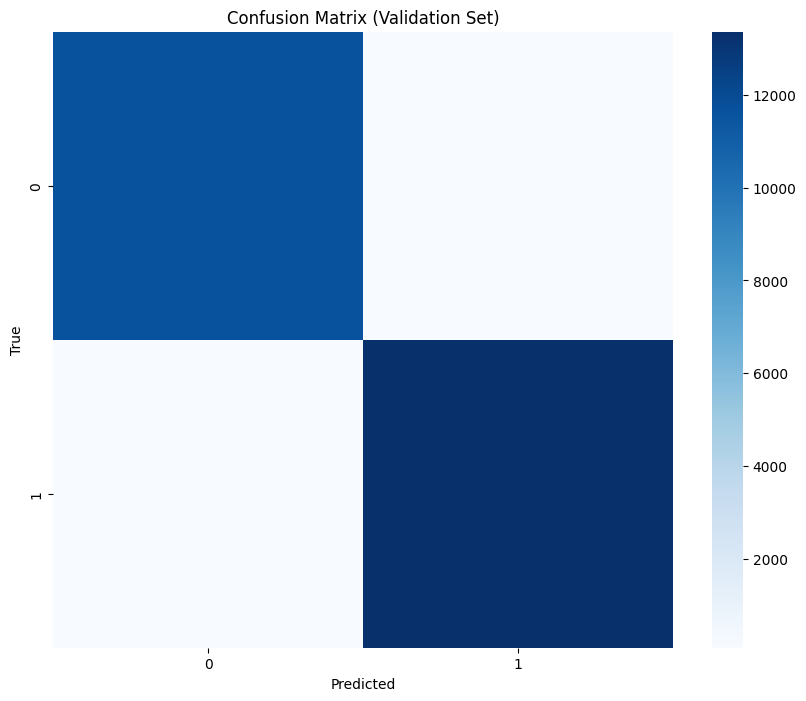

In [ ]:
# 📌 Cell 11: Visualization of Results

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Training vs Validation Loss
plt.figure(figsize=(12,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# 2. Validation Accuracy
plt.figure(figsize=(12,4))
plt.plot(val_accuracies, label="Val Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()

# 3. Validation F1 Score
plt.figure(figsize=(12,4))
plt.plot(val_f1s, label="Val F1 Score", marker="o", color="purple")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score over Epochs")
plt.legend()
plt.show()

# 4. Confusion Matrix (on validation set)
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = torch.argmax(model(xb), dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


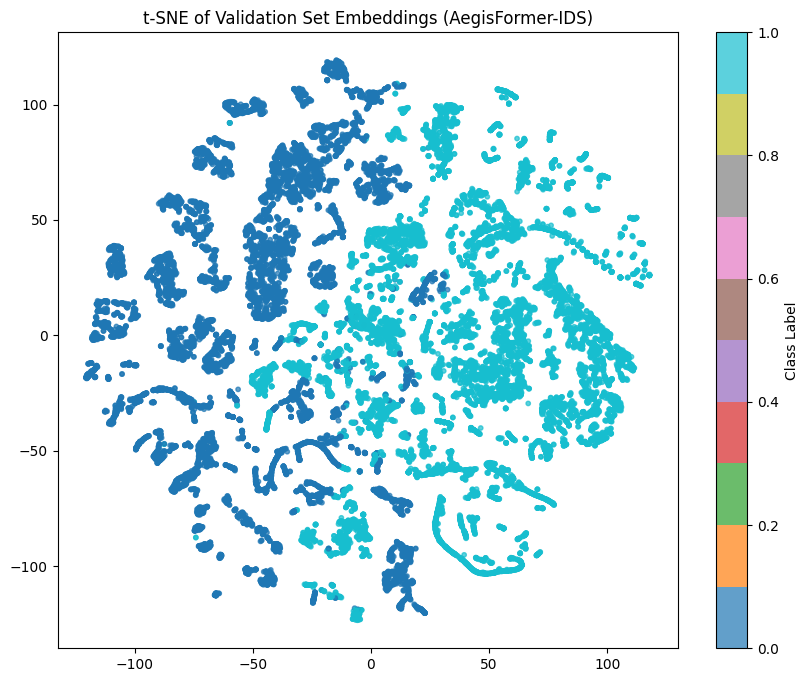

In [ ]:
# 📌 Cell 12: Visualize Feature Embeddings with t-SNE

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Collect embeddings from the trained model
model.eval()
embeddings, labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Take hidden representation from encoder input projection
        emb = model.input_proj(xb).cpu().numpy()
        embeddings.append(emb)
        labels.extend(yb.numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

# 🔹 Reduce dimensions (first with PCA for speed, then t-SNE)
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# 🔹 Plot t-SNE
plt.figure(figsize=(10,8))
scatter = plt.scatter(
    embeddings_2d[:,0], embeddings_2d[:,1],
    c=labels, cmap="tab10", alpha=0.7, s=10
)
plt.colorbar(scatter, label="Class Label")
plt.title("t-SNE of Validation Set Embeddings (AegisFormer-IDS)")
plt.show()
